# Expected number of background events 


## Objectives

* Estimate the total number of background events 

* number of selected background events in the energy enlarged window and in the RoI

## Analysis

We will use a *blind* data sample, data where the signal events have been removed by an selection, which we called *blind* selection.

The blind selection removes from the full data the signal events while maintains most of the bkg events.

We will compute the efficiency of the *blid* selection on simulated background samples, that is: $\epsilon^k_b$ with $k = \mathrm{Bi}, \mathrm{Tl}$

We sill estimate the number of background events in the *blind*, $n_b^k$ with $k = \mathrm{Bi}, \mathrm{Tl}$.

We estimate the number of background events in the RoI, given the selection efficiency in the RoI $\epsilon^k_{RoI}$

$$ 
n^k_{RoI} = \frac{\epsilon^k_{RoI}}{\epsilon^k_{b}} n^k_b
$$

We estimate also the number of background events in the enlarged energy window, $\epsilon^k_E$

$$ 
n^k_{E} = \frac{\epsilon^k_{E}}{\epsilon^k_{b}} n^k_b
$$

with $k = \mathrm{Bi}, \mathrm{Tl}$

Remember the selection in the RoI region has the following cuts:

        * sel_ntracks, sel_eblob2, sel_eroi

While the selection in the enlarged energy window:

        * sel_ntracks, sel_eblob2, sel_erange

## Estimation of the bkg events in the blind sample

We estimate the number of bkg events $n^\mathrm{Bi}_b, \, n^{\mathrm{Tl}}_b$ as those values that minimized the -2 log extended maximum likelihood.

We estimate first the pdf of the energy, $E$, of each bkg sample, $g_k(E), \;\; k = \mathrm{Bi}, \mathrm{Tl}$

We combine the pdfs int an extended likelihood, $\mathcal{L}({\bf E} |{\bf n}_n)$, where ${\bf n}_b = (n^{\mathrm{Bi}}_b, n^{\mathrm{Tl}}_b)$, and ${\bf E}$ are the energies of the $m$ events in the blind sample, $E_i, \;\, i= 1, \dots, m$.

$$
\mathcal{L}({\bf E} | {\bf n}_b) =  g(m | n_b) \, \Pi_{i=1}^m \sum_k \frac{n^k_b}{n_b}  \, g_k(E_i)
$$

Where $g(m | n_b)$ is the value of the poisson of the $m$ events in the blind sample given a mean of $n_b$ blind events.

Finally, we estimate the parameters, $n^\mathrm{Bi}_b, \, n^{\mathrm{Tl}}_b$, minimizing

$$
- 2 \log \mathcal{L}({\bf E} | {\bf n}_b).
$$

## Analysis

### Import modules

In [31]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
import numpy  as np
import tables as tb
import pandas as pd
import matplotlib.pyplot as plt

import scipy.stats     as stats  # statistics and Many PDFs 
#import scipy.optimize  as optimize # Minimice funtions

import warnings
warnings.filterwarnings('ignore')

In [33]:
# REMEMBER TO ADD Your Fanal FOLDER TO PYTHONPATH
import os
import sys
rootpath = os.getcwd()[:-15]
print('add path to PYTHONPATH : ', rootpath)
sys.path.insert(0, os.path.abspath(rootpath))

add path to PYTHONPATH :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2/


In [34]:
import core.pltext  as pltext   # extensions for plotting histograms
import core.hfit    as hfit     # extension to fit histograms
import core.efit    as efit     # Fit Utilites - Includes Extend Likelihood Fit with composite PDFs
import core.utils   as ut       # generic utilities
import ana.fanal    as fn       # analysis functions specific to fanal
import ana.pltfanal as pltfn    # plotting for fanal

import collpars    as collpars # collaboration specific parameters
pltext.style()

### Parameters

In [35]:
coll          = collpars.collaboration
sel_erange    = collpars.sel_erange
sel_eroi      = collpars.sel_eroi
eff_Bi_E      = collpars.eff_Bi_E
eff_Tl_E      = collpars.eff_Tl_E
eff_Bi_RoI    = collpars.eff_Bi_RoI
eff_Tl_RoI    = collpars.eff_Tl_RoI

print('Collaboration         : {:s}'.format(coll))
print('Energy range          : ({:6.3f}, {:6.3f}) MeV'.format(*sel_erange))
print('RoI    range          : ({:6.3f}, {:6.3f}) MeV'.format(*sel_eroi))
print('Bi eff in E range     : {:6.4f} %'.format(100.*eff_Bi_E))
print('Tl eff in E range     : {:6.4f} %'.format(100.*eff_Tl_E))
print('Bi eff in RoI         : {:6.4f} %'.format(100.*eff_Bi_RoI))
print('Tl eff in RoI         : {:6.4f} %'.format(100.*eff_Tl_RoI))

Collaboration         : new_beta
Energy range          : ( 2.400,  2.700) MeV
RoI    range          : ( 2.430,  2.480) MeV
Bi eff in E range     : 1.8000 %
Tl eff in E range     : 0.7300 %
Bi eff in RoI         : 1.5500 %
Tl eff in RoI         : 0.0194 %


### Data

In [36]:
#dirpath = '/Users/hernando/docencia/master/Fisica_Particulas/USC-Fanal/data/'
filename = '/data/fanal_' + coll + '.h5'
print('Data path and filename : ', rootpath + filename)

mcbi       = pd.read_hdf(rootpath + filename, key = 'mc/bi214')   # MC Bi
mctl       = pd.read_hdf(rootpath + filename, key = 'mc/tl208')   # MC Tl
data_blind = pd.read_hdf(rootpath + filename, key = 'data/blind') # blind data

mc_samples         = [mcbi, mctl]
sample_names       = ['Bi', 'Tl']
sample_names_latex = [r'$^{214}$Bi', r'$^{208}$Tl']

Data path and filename :  /Users/hernando/work/docencia/master/Fisica_Particulas/USC-Fanal-v2//data/fanal_new_beta.h5


### Estimate blind selection efficiency in MC

In [37]:
# apply the blind selection to the mc samples to obtaine blind mc samples

def efficiency(mask):
    return float(sum(mask)/len(mask))

mask_bi = fn.selection_blind(mcbi)
mask_tl = fn.selection_blind(mctl)

eff_Bi_blind = efficiency(mask_bi)
eff_Tl_blind = efficiency(mask_tl)

mc_blind_samples =  (mcbi[mask_bi], mctl[mask_tl])

print('Bi blind eff : {:6.4f} %'.format(100.*eff_Bi_blind))
print('Tl blind edd : {:6.4f} %'.format(100.*eff_Tl_blind))

Bi blind eff : 78.5375 %
Tl blind edd : 70.7461 %


## Energy distribution of the blind data and mc samples

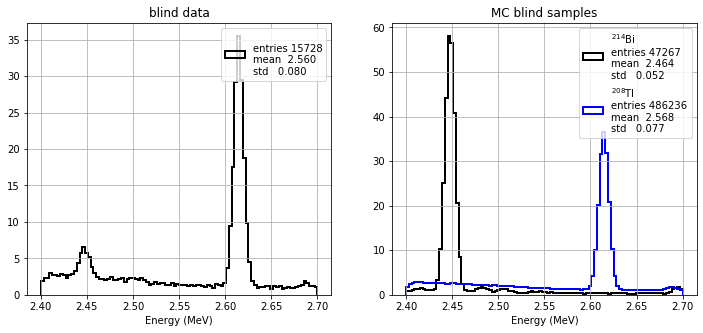

In [38]:
def plot_energy(df, label = '', bins = 100):
    pltext.hist(df.E, bins, range = sel_erange, label = label, density = True, lw = 2)
    plt.xlabel('Energy (MeV)'); 

subplot = pltext.canvas(2)
subplot(1)
plot_energy(data_blind)
plt.title('blind data');

subplot(2)
for i, df in enumerate(mc_blind_samples):
    plot_energy(df, label = sample_names_latex[i])
plt.legend(); plt.title('MC blind samples');

## Estimate the number of background events in the blind-data

Estimate the number of events of Bi and Tl:  
  
  * Obtain the pdfs distribution for a reference variable, i.e. energy, for each blind sample.

  * Generate a combined pdf where the parameters are the number of events of each sample.

  * Estimate the number of blind Tl and Bi events fitting the energy distribution to the combined pdf.

  * Compute the total number of Tl and Bi using the efficiencies of the blind selection in the MC samples.
  
Note:

  * There is an appendix in the NB to show the code step by step

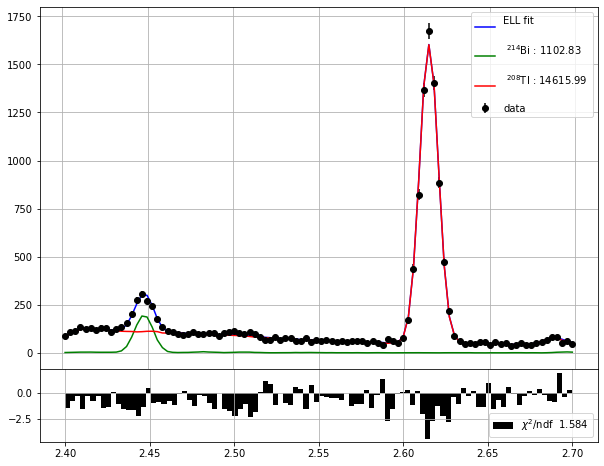

In [39]:
nguess = (1000., 1000.)

varname   = 'E'
refnames  = (varname,) 
refranges = (sel_erange,)

fit        = fn.prepare_fit_ell(mc_blind_samples, nguess, refnames, refranges)

result, enes, ell, _ = fit(data_blind)
nevts_blind          = result.x

pltfn.plot_fit_ell(enes, nevts_blind, ell, parnames = sample_names_latex);

### Compute the total number of background events

In [40]:
n_Bi_blind = nevts_blind[0]
n_Tl_blind = nevts_blind[1]

print(' number of blind events Bi : {:6.3f}'.format(n_Bi_blind))
print(' number of blind events Tl : {:6.3f}'.format(n_Tl_blind))

 number of blind events Bi : 1102.825
 number of blind events Tl : 14615.988


### Number of background events in RoI and E ragne

In [41]:
n_Bi_total = n_Bi_blind / eff_Bi_blind
n_Tl_total = n_Tl_blind / eff_Tl_blind

n_Bi_E = n_Bi_total * eff_Bi_E
n_Tl_E = n_Tl_total * eff_Tl_E

n_Bi_RoI = n_Bi_total * eff_Bi_RoI
n_Tl_RoI = n_Tl_total * eff_Tl_RoI

print(' number of events total Bi      : {:6.3f}'.format(n_Bi_total))
print(' number of events total Tl      : {:6.3f}'.format(n_Tl_total))

print(' number of events in E range Bi : {:6.3f}'.format(n_Bi_E))
print(' number of events in E range Tl : {:6.3f}'.format(n_Tl_E))

print(' number of events in RoI Bi     : {:6.3f}'.format(n_Bi_RoI))
print(' number of events in RoI Tl     : {:6.3f}'.format(n_Tl_RoI))

 number of events total Bi      : 1404.203
 number of events total Tl      : 20659.771
 number of events in E range Bi : 25.276
 number of events in E range Tl : 150.816
 number of events in RoI Bi     : 21.765
 number of events in RoI Tl     :  4.008


## Write out

In [42]:
exposures  = {'new_alpha': 500, 'new_beta': 1000, 'new_gamma': 1000,
              'new_delta': 3000, 'new_epsilon': 3000}
acc_bb     = 0.79

exposure   = exposures[collaboration]

write = True
if (write):
    of = open('collpars.py', 'a')
    of.write('exposure        = {:6.2f}'.format(exposure)+' # kg y \n')
    of.write('acc_bb          = {:6.3f}'.format(acc_bb)+'\n')

    of.write('eff_Bi_blind    = {:6.3f}'.format(eff_Bi_blind)+'\n')
    of.write('eff_Tl_blind    = {:6.3f}'.format(eff_Tl_blind)+'\n')

    of.write('n_Bi_total      = {:6.3f}'.format(n_Bi_total)+'\n')
    of.write('n_Bi_blind      = {:6.3f}'.format(n_Bi_blind)+'\n')
    of.write('n_Bi_E          = {:6.3f}'.format(n_Bi_E)+'\n')
    of.write('n_Bi_RoI        = {:6.3f}'.format(n_Bi_RoI)+'\n')

    of.write('n_Tl_total      = {:6.3f}'.format(n_Tl_total)+'\n')
    of.write('n_Tl_blind      = {:6.3f}'.format(n_Tl_blind)+'\n')
    of.write('n_Tl_E          = {:6.3f}'.format(n_Tl_E)+'\n')
    of.write('n_Tl_RoI        = {:6.3f}'.format(n_Tl_RoI)+'\n')
    of.close()